# Medford Disaster Router
<br>
<b>Contributors: Michael Ruggiero, Cengiz Imga, Dali Souayah

# Index

1. [Problem Statement](#PS)
2. [Data Preparation](#Data)
    1. [Major Road Functions](#MRF)
    2. [Routing](#Route)
    3. [Disaster Radius](#Dis)
    4. [Edge Manipulation and Visualizations](#EM)
3. [Dataset Creation](#Maker)
    1. [Data Cleaning](#Clean)
    2. [Statistics](#Stats)

In [24]:
# Function imports
import numpy as np
import pandas as pd
import networkx as nx
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

ox.config(use_cache=True, log_console=True)
ox.__version__

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## 1. Problem Statement <a id = "PS"></a>

1) Build a NLP model that identifies peaks in twitter (or other social media) that would hint to road closures or disasters locations with Google maps

2) translate those identified locations into flags in a map

3) reflect the affected roads into a map in red color

4) produce a map of valid rescue roads/escape routes

## 2. Data Collection/Import Medford <a id = "Data"></a>

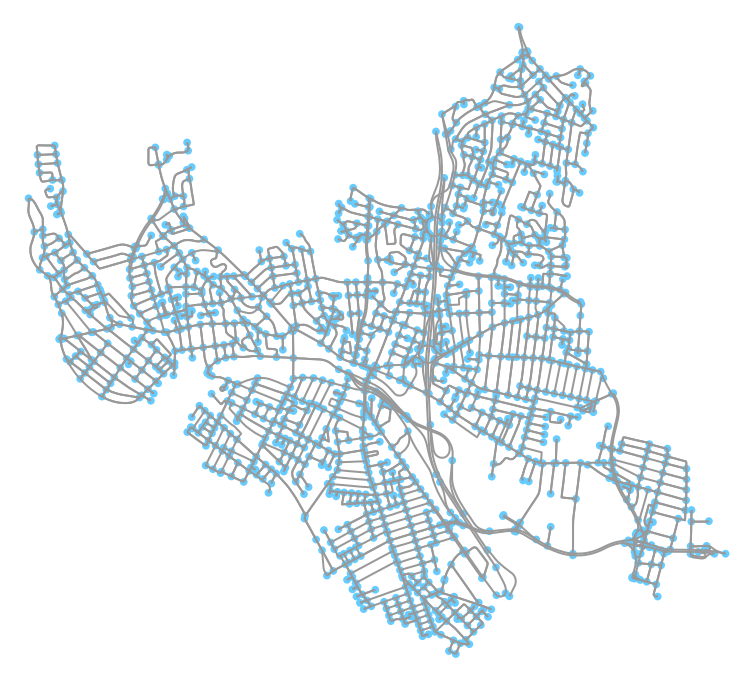

In [25]:
# get a graph for some city
place = {'city' : 'Medford',
         'state' : 'MA',
         'country' : 'USA'}
medford = ox.graph_from_place(place, network_type='drive')
fig, ax = ox.plot_graph(medford)

In [26]:
# what sized area does our network cover in square meters?
medford_proj = ox.project_graph(medford)
nodes_proj = ox.graph_to_gdfs(medford_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
print(graph_area_m)

# show basic stats about the network
medford_stats = ox.basic_stats(medford_proj, 
                               area=graph_area_m, 
                               clean_intersects=True,
                               circuity_dist='euclidean')

# medford_stats = ox.extended_stats(medford_proj, ecc=True, bc=True, cc=True)

pd.DataFrame(medford_stats).set_index("streets_per_node_counts")

21010917.099306576


,n,m,k_avg,intersection_count,streets_per_node_avg,streets_per_node_proportion,edge_length_total,edge_length_avg,street_length_total,street_length_avg,street_segments_count,node_density_km,intersection_density_km,edge_density_km,street_density_km,circuity_avg,self_loop_proportion,clean_intersection_count,clean_intersection_density_km
streets_per_node_counts,,,,,,,,,,,,,,,,,,,
0,1569,3862,4.922881,1361,2.905672,0.000000,397167.386,102.83982,239165.907,106.485266,2246,74.675465,64.775849,18902.905767,11382.93516,1.0391,0.002071,1115,53.06765
208,1569,3862,4.922881,1361,2.905672,0.132569,397167.386,102.83982,239165.907,106.485266,2246,74.675465,64.775849,18902.905767,11382.93516,1.0391,0.002071,1115,53.06765
4,1569,3862,4.922881,1361,2.905672,0.002549,397167.386,102.83982,239165.907,106.485266,2246,74.675465,64.775849,18902.905767,11382.93516,1.0391,0.002071,1115,53.06765
1094,1569,3862,4.922881,1361,2.905672,0.697259,397167.386,102.83982,239165.907,106.485266,2246,74.675465,64.775849,18902.905767,11382.93516,1.0391,0.002071,1115,53.06765
254,1569,3862,4.922881,1361,2.905672,0.161887,397167.386,102.83982,239165.907,106.485266,2246,74.675465,64.775849,18902.905767,11382.93516,1.0391,0.002071,1115,53.06765
9,1569,3862,4.922881,1361,2.905672,0.005736,397167.386,102.83982,239165.907,106.485266,2246,74.675465,64.775849,18902.905767,11382.93516,1.0391,0.002071,1115,53.06765


In [27]:
# Edge and Node projection
nodes_med, edges_med = ox.graph_to_gdfs(medford, nodes=True, edges=True)

In [28]:
nodes_med.head(2)

,highway,osmid,ref,x,y,geometry
66478081,turning_circle,66478081,NaN,-71.100780,42.429287,POINT (-71.1007798 42.4292871)
1095962629,traffic_signals,1095962629,NaN,-71.110312,42.415123,POINT (-71.1103119 42.4151234)


In [29]:
nodes_med.shape

(1569, 6)

## 2a. Major Roads Functions<a id = "MRF"></a>

In [33]:
#Functions built for this project
import graph_functions as gf

In [34]:
import numpy as np
import pandas as pd
import networkx as nx
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import webcolors

def random_point(lower = -180, higher = 180):
    return (np.random.uniform(low=lower, high=higher),
            np.random.uniform(low=lower, high=higher))

    print(random_point())

def colorer(color):
    answer = []
    for i in color:
        answer.append(int(255 *i))

    return answer

def closest_color(color):
    min_colors = {}
    for key, name in webcolors.css3_hex_to_names.items():
        red, green, blue = webcolors.hex_to_rgb(key)
        rd = (red - color[0]) ** 2
        gd = (green - color[1]) ** 2
        bd = (blue - color[2]) ** 2
        min_colors[(rd + gd + bd)] = name
    return min_colors[min(min_colors.keys())]

def random_color_matrix(dictionary):
    """generates a random RBG dictionary from three linspaces"""

    keys = list(dictionary.keys())
    size = len(keys)

    #These are three three random linspaces
    A = np.linspace(.2,.8, size)
    np.random.shuffle(A)

    B = np.linspace(.2,.8, size)
    np.random.shuffle(B)

    C = np.linspace(.2,.8, size)
    np.random.shuffle(C)

    color_dictionary = {"minor" : 'whitesmoke'}

    for i in range(len(keys)):
        color_dictionary[keys[i]] = closest_color(colorer((A[i],
                                                           B[i],
                                                           C[i])))
    color_dictionary["minor"] = 'whitesmoke'

    return color_dictionary

def node_labeler(node, color_dictionary, dictionary, paint_mode = 0):
    """
    labeles nodes based on dictionary entries

    paint_mode = 0, produces a name
    otherwise, produces RGB color

    """
    answer = []
    for key in dictionary:
        if node in dictionary[key]:
            answer.append(key)

    if paint_mode == 0:
        if len(answer) == 0 or answer[0] == "minor":
            return "minor"
        elif len(answer) == 1:
            return answer[0]
        else: return " ".join(answer)

    else:
        if len(answer) == 0:
            return color_dictionary["minor"]
        elif len(answer) == 1:
            return color_dictionary[answer[0]]
        else:
            return "black"

def node_roader(edges_df,nodes_df):
    """
    edges_df is the edge projection, nodes_df is the node projection
    
    a
    """
    major_roads = set(edges_df[edges_df.ref.notna()].ref.values)
    major_roads = dict.fromkeys(major_roads, set())
    color_dict = random_color_matrix(major_roads)
    
    
    #Return printout to terminal and build major_road dict
    for road in major_roads:
        print("{:<5} \t nodes in {:>5} \t colored \t {}".format(len(edges_df[edges_df.ref == road]),
                                                 road,
                                                 color_dict[road]))
              
        major_roads[road] = set(edges_df[edges_df.ref == road].u) | \
                            set(edges_df[edges_df.ref == road].v)
    
    
    #Make Colored Columns for edges
    edges_df.ref.fillna("minor", inplace = True) # Remove all NaN 
    edges_df["color"] = edges_df.ref.apply(lambda a: color_dict[a])
    
    #Make Colored columns for nodes
    nodes_df["major"] = nodes_df.osmid.apply(lambda a: node_labeler(a,
                                                                    color_dict,
                                                                    major_roads,0))
    nodes_df["color"] = nodes_df.osmid.apply(lambda a: node_labeler(a,
                                                                    color_dict,
                                                                    major_roads,1))
    
    nodes_df["major_inter"] = nodes_df.major.apply(lambda a: a.count(" "))
    
    #generate graph
    graph = ox.gdfs_to_graph(nodes_df, edges_df)
    
    
    #Build coloring lines
    edge_color = [edges_df[(edges_df.u == i[0]) & (edges_df.v == i[1])].color.values[0] for i in graph.edges()]
    node_color = [nodes_df.loc[i].color for i in graph.nodes()]
    
    ox.plot_graph(graph,
                  node_size=10,
                  node_color = node_color, 
                  edge_color = edge_color,
                  annotate=False,
                  dpi = 600,
                  edge_alpha = .5
                );
    
    data_dictionary = {"graph":graph,
                       "edges":edges_df,
                       "nodes":nodes_df,
                       "major_roads":major_roads,
                       "color_dictionary":color_dict,
                       "edge_color":edge_color,
                       "node_color":node_color}
    
    return data_dictionary

medford_data = gf.node_roader(edges_med,nodes_med)

ValueError: Unknown format code '-' for object of type 'str'

In [9]:
edges_med, nodes_med, = medford_data["edges"], medford_data["nodes"]

In [10]:
edges_med.ref.value_counts()

minor          3475
MA 60           143
MA 38            96
MA 28            76
MA 16            51
I 93             12
MA 38;MA 60       5
MA 16;MA 38       4
Name: ref, dtype: int64

In [11]:
nodes_med.major_inter.value_counts()

0    1286
1     268
3       6
4       4
6       3
2       2
Name: major_inter, dtype: int64

In [12]:
#Long/Lat information
nodes_med[["x","y"]].describe()

,x,y
count,1569.000000,1569.000000
mean,-71.107867,42.419430
std,0.015947,0.010365
min,-71.145410,42.396426
25%,-71.118687,42.411989
50%,-71.105661,42.420096
75%,-71.095526,42.426626
max,-71.073105,42.444456


## 2b. Routing<a id = "Route"></a>

In [13]:
#A function to generate a random lat/long point
gf.random_point()

(2.4051467582997077, -72.28871588453177)

In [14]:
random_point_A = gf.random_point()
random_point_B = gf.random_point()

# get the nearest network node to each random point
orig_node = ox.get_nearest_node(medford, random_point_A)
dest_node = ox.get_nearest_node(medford, random_point_B)

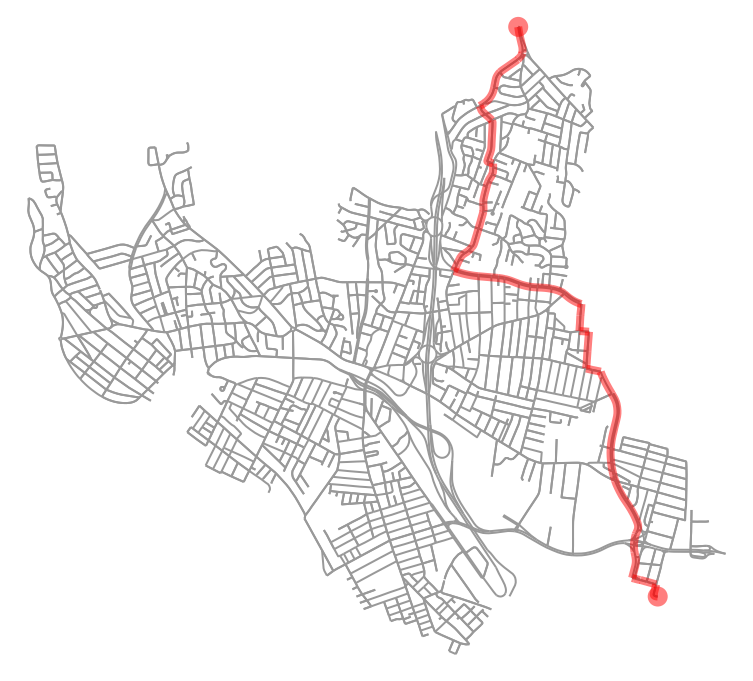

In [15]:
# find the route between these nodes then plot it
route = nx.shortest_path(medford, orig_node, dest_node, weight='length')
fig, ax = ox.plot_graph_route(medford, route, node_size=0)

In [16]:
# Length of route in meters
nx.shortest_path_length(medford, orig_node, dest_node, weight='length')

6502.639999999999

In [17]:
# Absolute Distance between two nodes (as the crow flies)
ox.great_circle_vec(medford.node[orig_node]['y'], medford.node[orig_node]['x'],
                    medford.node[dest_node]['y'], medford.node[dest_node]['x'])

4994.183069960721

## 2c. Disaster Radius<a id = "Dis"></a>

In [18]:
nodes_med[["y","x"]].sample(1).values[0]

array([ 42.412419 , -71.1152712])

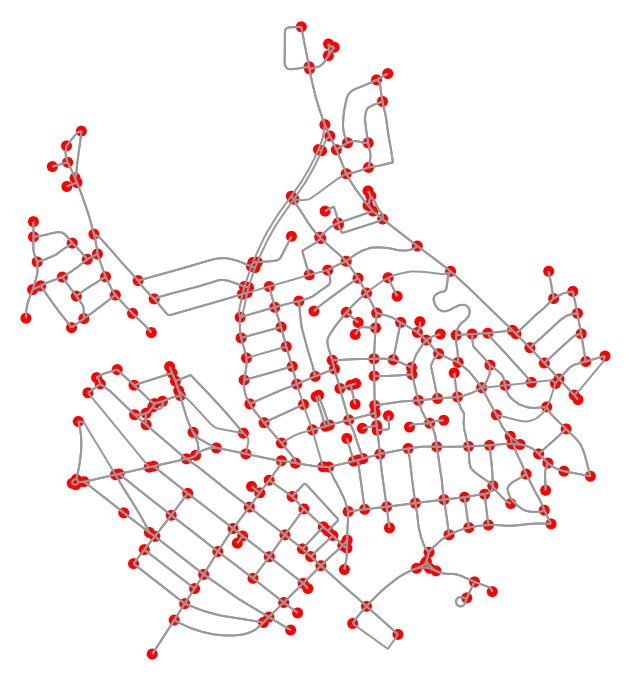

In [19]:
#returns a graphs object of a disater
disaster = gf.disaster_generator(nodes_med, 0,1500)

In [20]:
nodes_dis, edges_dis = ox.graph_to_gdfs(disaster)

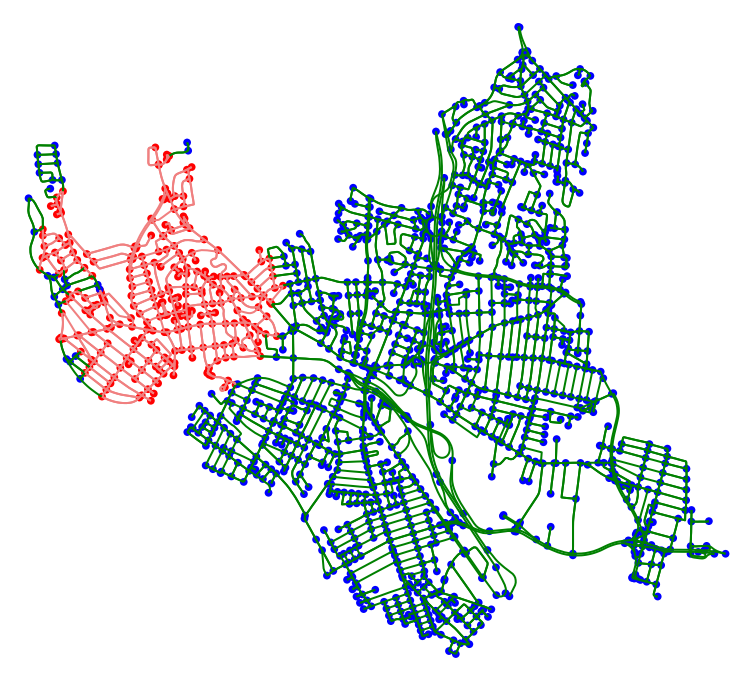

(<Figure size 650.491x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1217353c8>)

In [21]:
#Set Colors
ec = ['lightcoral' if i in disaster.edges() else 'green' for i in medford.edges()]
nc = ['red' if i in disaster.nodes() else 'blue' for i in medford.nodes()]

#Plot energency grid
ox.plot_graph(medford, node_size=15, node_color = nc ,edge_color=ec)

53975 roads remain of 65654 total roads


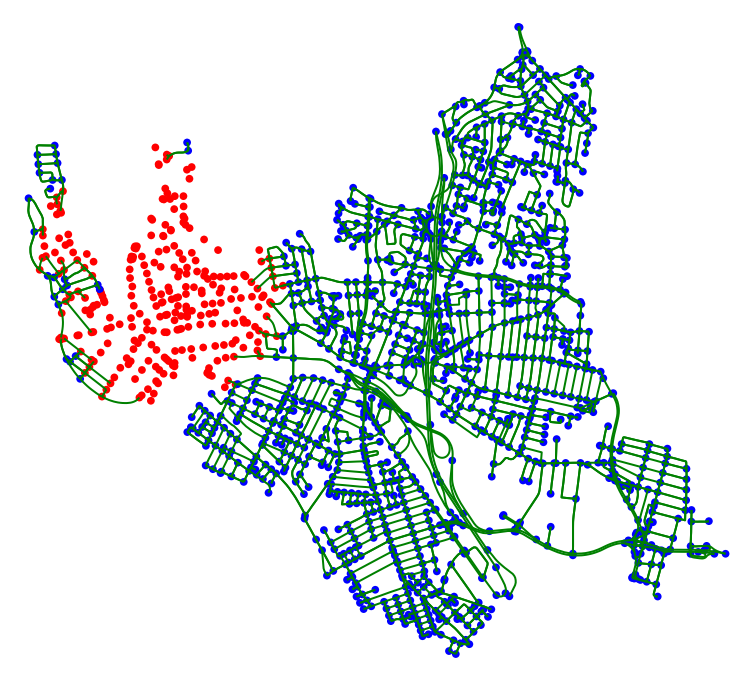

In [22]:
medford_disaster = gf.road_kill(disaster, nodes_med, edges_med)

## 2d. Edge Manipulation and Visualizations<a id = "EM"></a>


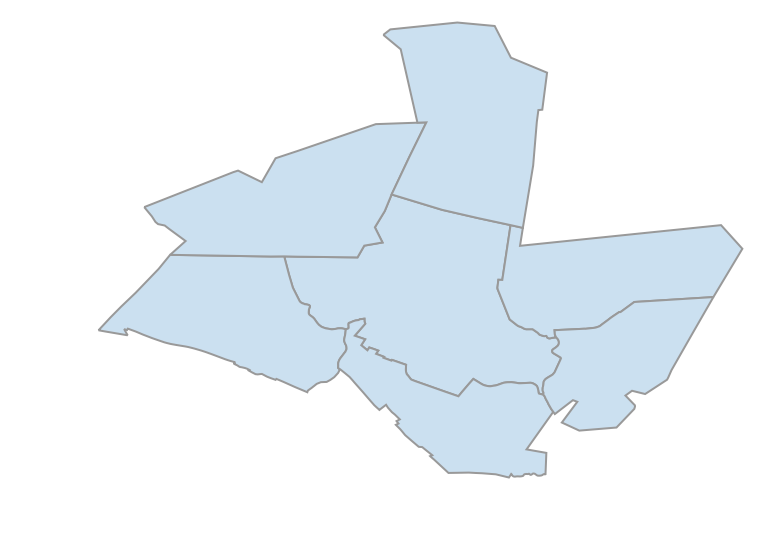

In [23]:
# get the boundary polygons for neighboring cities, save as shapefile, project to UTM, and plot
place_names = ['Medford, MA, USA', 
               'Arlington, MA, USA',
               'Somerville, MA, USA',
               'Malden, MA, USA',
#                'Melrose, MA, USA',
               'Winchester, MA, USA',
               'Stoneham, MA, USA',
               'Everett, MA, USA',
              ]
medford_area = ox.gdf_from_places(place_names)
fig, ax = ox.plot_shape(medford_area)

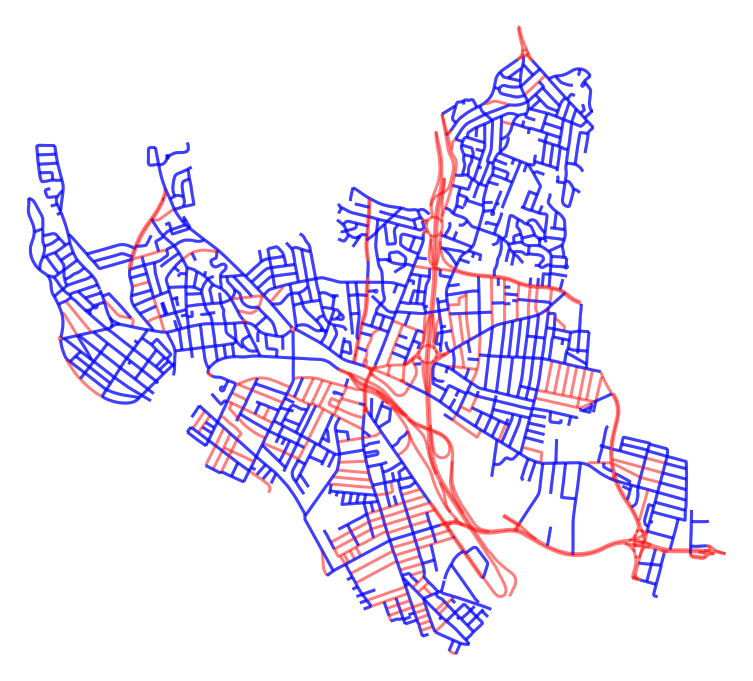

In [24]:
# highlight one-way roads
ec = ['r' if data['oneway'] else 'b' for u, v, key, data in medford.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(medford, node_size=0, edge_color=ec, edge_linewidth=1.5, edge_alpha=0.5)

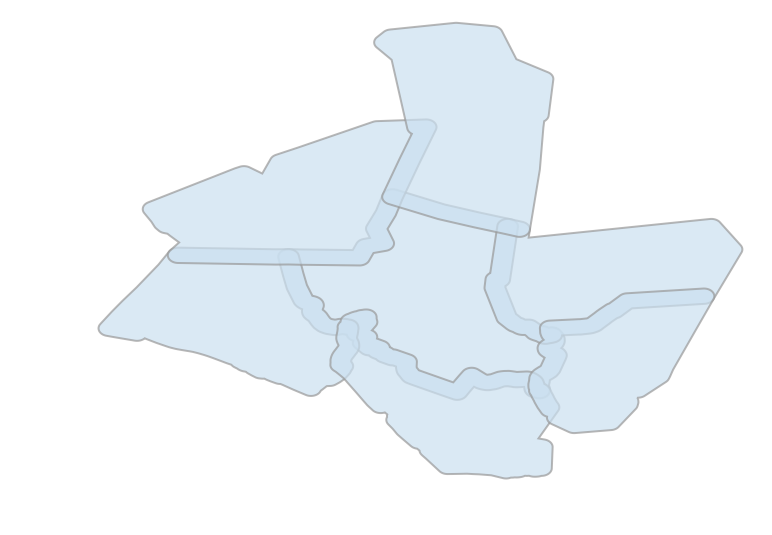

In [25]:
#Neighboor hoods buffered
neigboors_buffered = ox.gdf_from_places(place_names, gdf_name='neighboors', buffer_dist=250)
fig, ax = ox.plot_shape(neigboors_buffered, alpha=0.7)

## 3. Data Creation <a id = "Maker"></a>

In [26]:
# DF builder of start/end nodes with long/lat and times 
router = gf.random_zone_picker(nodes_med, 4_000)
#router.to_csv("routes_with_zones.csv")

In [27]:
router.head()

,osmid_start,x_start,y_start,osmid_end,x_end,y_end,Time
0,987868067,-71.079482,42.404116,1755511237,-71.091879,42.428353,8:30
1,987868067,-71.079482,42.404116,1755511237,-71.091879,42.428353,15:30
2,987868067,-71.079482,42.404116,1755511237,-71.091879,42.428353,17:30
3,66481271,-71.125404,42.410395,66433382,-71.090232,42.435266,8:30
4,66481271,-71.125404,42.410395,66433382,-71.090232,42.435266,15:30


In [41]:
# network from address, including only nodes within 6.5km along the network from city hall
neighbor = ox.graph_from_address(address='85 George P. Hassett Drive,\
                                    Medford, MA 02155',
                                    distance=6500, distance_type='network', network_type='drive')

# you can project the network to UTM (zone calculated automatically)
neighbor_projected = ox.project_graph(neighbor)

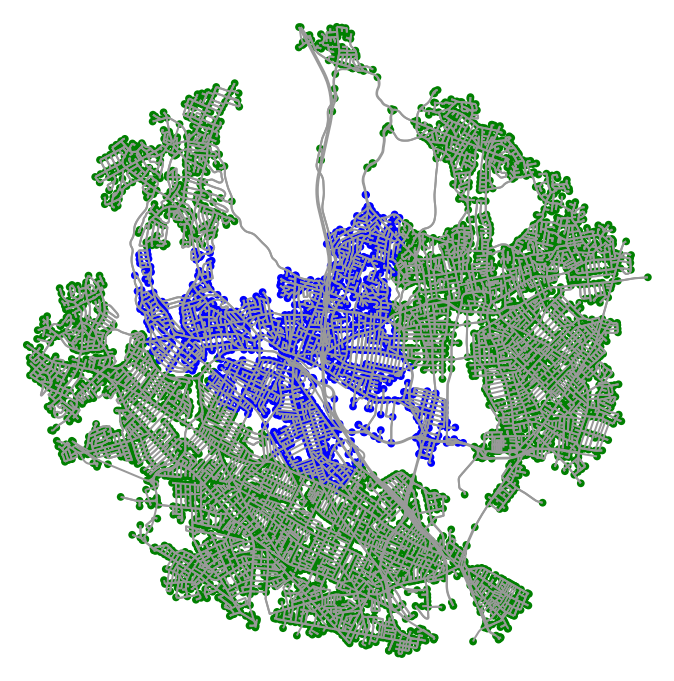

In [42]:
# Edge and Node projection
nodes_area, edges_area = ox.graph_to_gdfs(neighbor_projected,
                                        nodes=True,
                                        edges=True)

nc = ['blue' if i in medford.nodes() else 'green' for i in neighbor.nodes()]

ox.plot_graph(neighbor,
              node_size=15,
              node_color = nc);

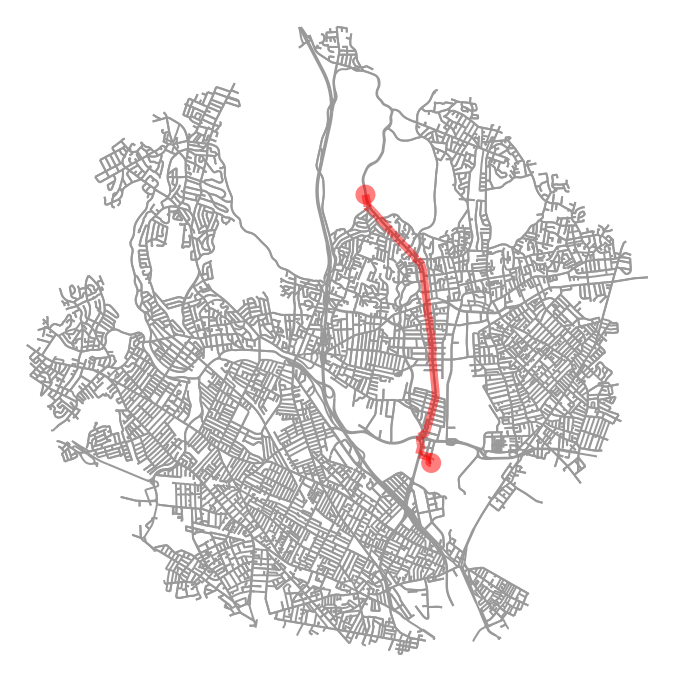

In [31]:
# find the route between these nodes then plot it
route = nx.shortest_path(neighbor, orig_node, dest_node, weight='length')
fig, ax = ox.plot_graph_route(neighbor, route, node_size=0)

105   	 nodes in US 3;MA 2A 	 colored 	 darkslategrey
24    	 nodes in  I 93 	 colored 	 olivedrab
5     	 nodes in US 3;MA 2A;MA 60 	 colored 	 slategrey
120   	 nodes in MA 16 	 colored 	 darkgrey
165   	 nodes in MA 28 	 colored 	 rosybrown
182   	 nodes in MA 38 	 colored 	 darkolivegreen
161   	 nodes in MA 99 	 colored 	 slateblue
140   	 nodes in MA 2A 	 colored 	 limegreen
26    	 nodes in US 3;MA 2;MA 16 	 colored 	 mediumpurple
4     	 nodes in MA 16;MA 38 	 colored 	 darkkhaki
42    	 nodes in  US 3 	 colored 	 mediumseagreen
5     	 nodes in MA 38;MA 60 	 colored 	 darkorchid
319   	 nodes in MA 60 	 colored 	 lightslategrey
13    	 nodes in US 3;MA 16 	 colored 	 dimgrey
8     	 nodes in  MA 2 	 colored 	 tan


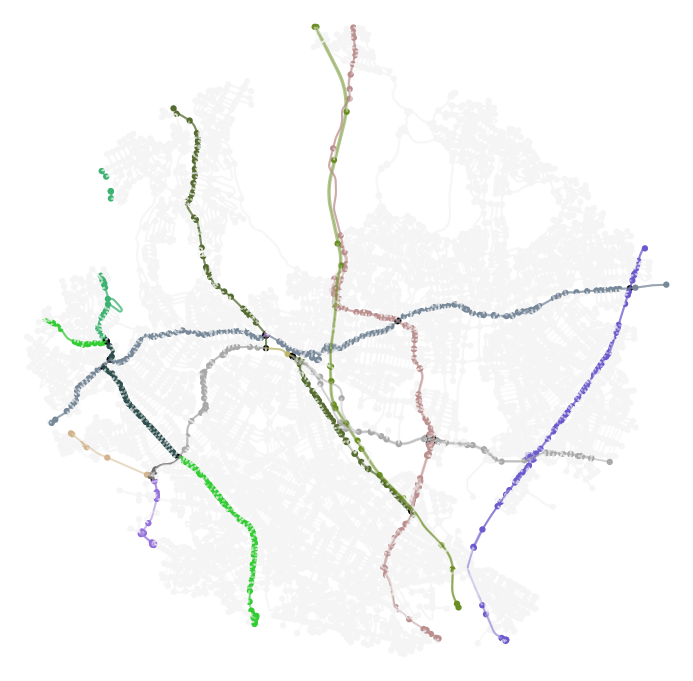

In [33]:
neighbor_data = gf.node_roader(edges_area,nodes_area)

In [49]:
nodes_area, edges_area = neighbor_data["nodes"], neighbor_data["edges"]

In [50]:
edges_area.color.value_counts()

whitesmoke        16819
lightslategrey      319
darkolivegreen      182
rosybrown           165
slateblue           161
limegreen           140
darkgrey            120
darkslategrey       105
mediumseagreen       42
mediumpurple         26
olivedrab            24
dimgrey              13
tan                   8
darkorchid            5
slategrey             5
darkkhaki             4
Name: color, dtype: int64

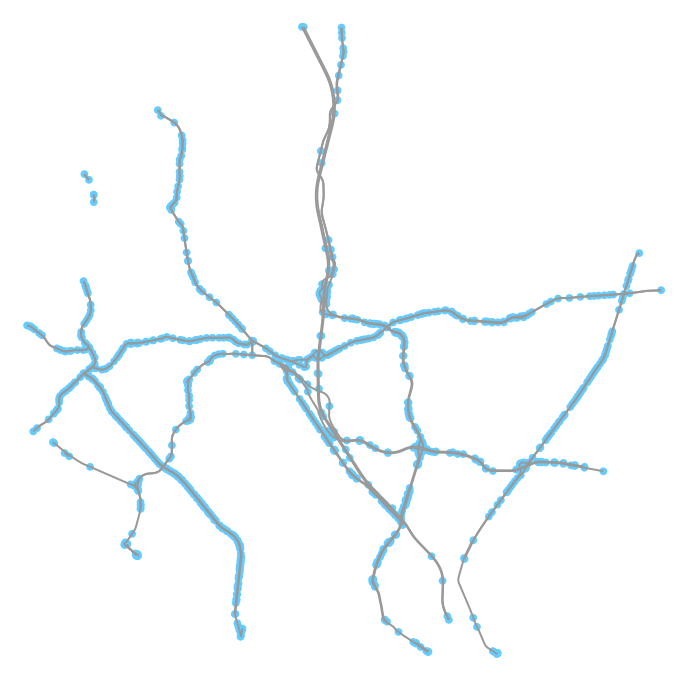

In [52]:
major_nodes_area = nodes_area[nodes_area.major != "minor"].copy()
major_edges_area = edges_area[edges_area.ref != "minor"].copy()

major_nodes_area.reset_index(inplace = True)
major_edges_area.reset_index(inplace = True)

minor_nodes_area = nodes_area[nodes_area.major == "minor"]

kill = np.asarray(minor_nodes_area.osmid.values)

major_roads = ox.gdfs_to_graph(nodes_area,
                     major_edges_area)

for i in kill:
    major_roads.remove_node(i)

ox.plot_graph(major_roads);

In [186]:
nx.degree_histogram(major_roads)

[0, 22, 490, 10, 384, 4, 7, 0, 1]

In [2]:
def intersection(graph):
    """Produces a dictionary for all of the nodes based on degree from a graph"""
    inter_dict = {}
    degree_list = nx.degree_histogram(graph)
    
    for i in range(len(degree_list)):
        node_list = []
        for j in graph.nodes():
            if nx.degree(graph,j) == i:
                node_list.append(j)

        inter_dics[i] = node_list
            
    return inter_dict
    
    
        
        
        
        
#     for i in major_roads.nodes():
#         if nx.degree(major_roads,i) != :
#                 print(i, major_roads.edges(i))

In [3]:
intersection(major_roads)

NameError: name 'major_roads' is not defined

In [53]:
nodes_major, edges_major = ox.graph_to_gdfs(major_roads)

In [55]:
nx.degree_histogram(major_roads)

[0, 22, 490, 10, 384, 4, 7, 0, 1]

In [57]:
nodes_major.head()

,color,geometry,highway,lat,lon,major,major_inter,osmid,ref,x,y
67027002,darkgrey,POINT (329612.2240064438 4696626.039258881),NaN,42.403244,-71.070468,MA 16,1,67027002,NaN,329612.224006,4.696626e+06
67027031,slateblue,POINT (330213.0882128028 4696141.592966977),NaN,42.399015,-71.063028,MA 99,1,67027031,NaN,330213.088213,4.696142e+06
66453596,rosybrown,POINT (327136.3849736558 4699188.67337465),traffic_signals,42.425760,-71.101303,MA 28,1,66453596,NaN,327136.384974,4.699189e+06
66486371,lightslategrey,POINT (326693.2213593228 4698400.07083477),traffic_signals,42.418564,-71.106449,MA 60,1,66486371,NaN,326693.221359,4.698400e+06
3804299390,darkolivegreen,POINT (328035.5764281429 4695840.657972014),NaN,42.395828,-71.089379,MA 38,1,3804299390,NaN,328035.576428,4.695841e+06


In [59]:
nodes_major["degree"] = nodes_major.osmid.apply(lambda a: nx.degree(major_roads, a))

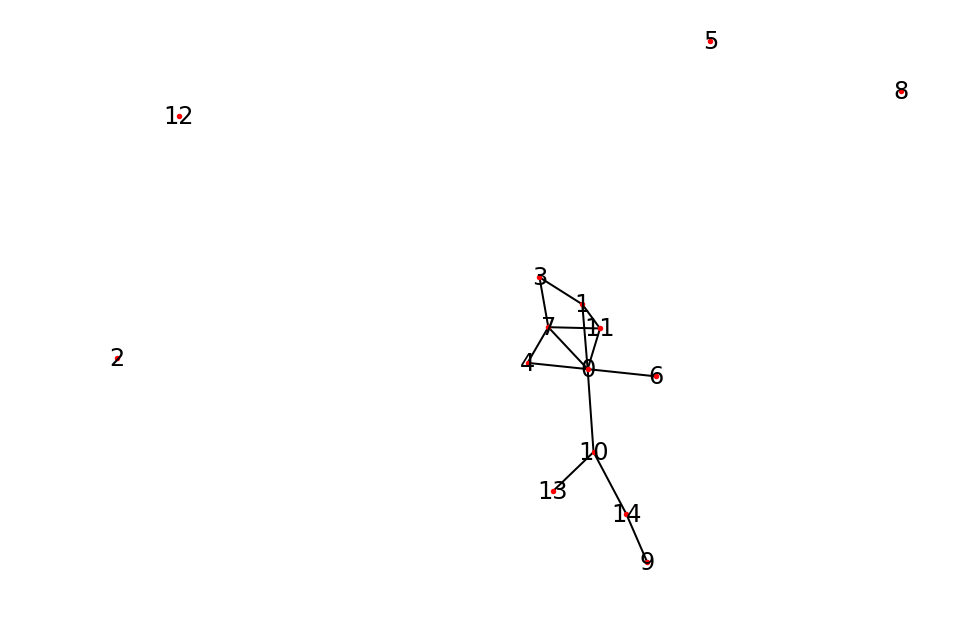

In [182]:
test = nx.gnm_random_graph(15, 14)
nx.draw(test,
        node_size=3,
        pos=nx.spring_layout(test),
        with_labels = True)

In [183]:
test.edges()

EdgeView([(0, 11), (0, 4), (0, 1), (0, 7), (0, 6), (0, 10), (1, 11), (1, 3), (3, 7), (4, 7), (7, 11), (9, 14), (10, 13), (10, 14)])

In [184]:
test.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14))

In [185]:
if nx.degree_histogram(test)[2] > 0:
    print(nx.degree_histogram(test))
    for i in test.nodes():
        if nx.degree(test,i) == 2:
            print(i, test.edges(i))

[4, 3, 3, 3, 1, 0, 1]
3 [(3, 1), (3, 7)]
4 [(4, 0), (4, 7)]
14 [(14, 10), (14, 9)]


In [177]:
set(item for sublist in test.edges(2) for item in sublist) - {2}

{1, 14}

In [180]:
test = nx.contracted_nodes(test, 2, 14, self_loops=True)
test = nx.contracted_nodes(test, 2, 1, self_loops = True)

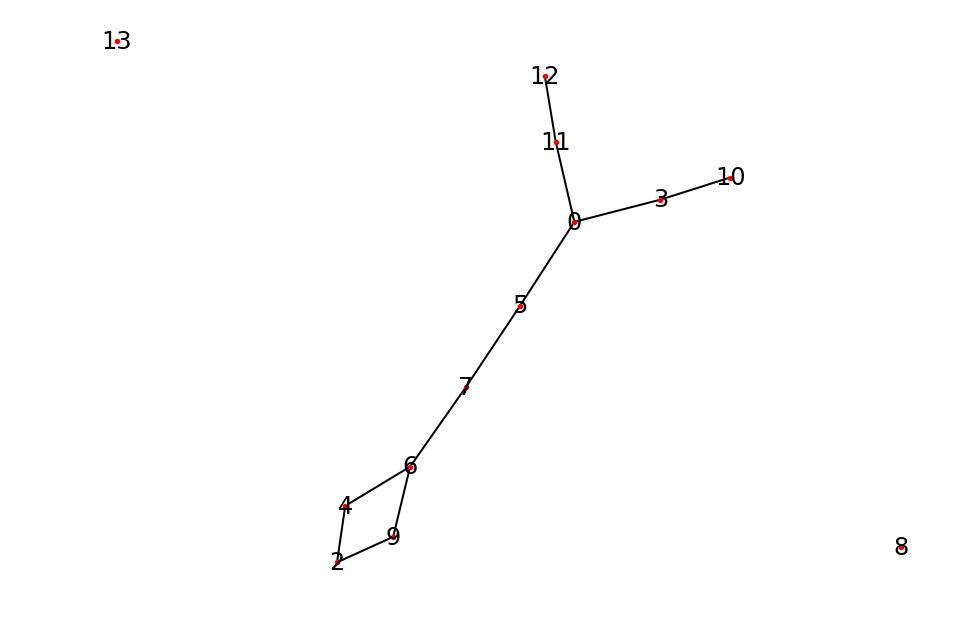

In [181]:
nx.draw(test,
        node_size=3,
        pos=nx.spring_layout(test), 
        with_labels = True)

In [151]:
for i in test.nodes():
    if nx.degree(test,i) == 2:
        print(i, test.edges(i))
        print("\n")

0 [(0, 1), (0, 6)]


2 [(2, 7), (2, 13)]


7 [(7, 2), (7, 9)]


10 [(10, 1), (10, 14)]


14 [(14, 3), (14, 10)]




In [ ]:
test = nx.contracted_nodes(test, 9, 5, self_loops=True)

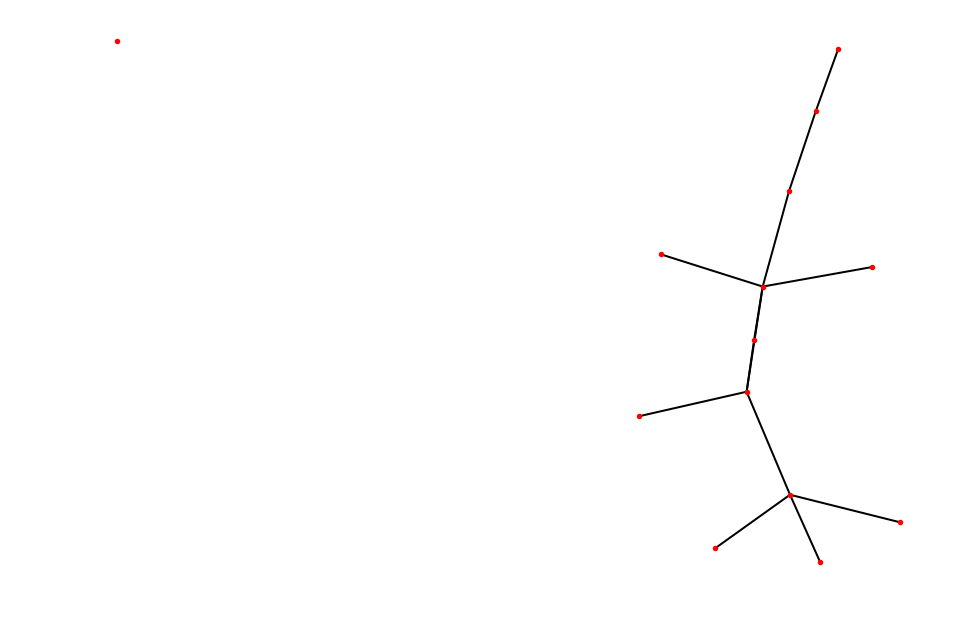

In [127]:
nx.draw(test,
        node_size=3,
        pos=nx.spring_layout(test))